In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve)
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# Data loading

In [72]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 20) (8639, 20)
(34554, 1) (8639, 1)


In [73]:
X_train

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,16873.0,301.303571,Senior,none,no contact
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,2.0,0.114286,Middle-aged,low,long ago
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,451.0,11.000000,Middle-aged,none,no contact
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,-142.0,-4.733333,Young,none,no contact
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,131.0,2.519231,Senior,none,no contact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34549,60,retired,married,secondary,2060,0,0,cellular,4.912655,95,4,failure,29-jun,10300,14060,412.0,33.770492,Senior,medium,long ago
34550,32,management,single,tertiary,0,0,0,cellular,4.060443,-1,0,other,19-nov,0,28000,0.0,0.000000,Middle-aged,none,no contact
34551,38,blue-collar,married,primary,0,0,0,unknown,5.347108,-1,0,other,13-may,0,16000,0.0,0.000000,Middle-aged,none,no contact
34552,30,admin.,single,secondary,154,1,0,cellular,3.218876,-1,0,other,21-nov,154,22154,154.0,4.967742,Young,none,no contact


# Baseline Model

## Encoding

In [76]:
# creating a dictionary to store LabelEncoder objects
label_encoders = {}

# lets slice the last 3 characters for 'contact_date'
X_train['contact_date'] = X_train['contact_date'].str[-3:]
X_test['contact_date'] = X_test['contact_date'].str[-3:]

# lets first create LabelEncoder for 'contact_date'
label_encoders['contact_date'] = LabelEncoder()

X_train['contact_date'] = label_encoders['contact_date'].fit_transform(X_train['contact_date'])
X_test['contact_date'] = label_encoders['contact_date'].transform(X_test['contact_date'])

# then, get all the categorical columns of object type
categorical_columns = X_train.select_dtypes(include=['object']).columns.difference(['contact_date'])

# encoding each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    
    # fit and transform for X_train
    X_train[column] = label_encoders[column].fit_transform(X_train[column])
    
    # transform X_test using the same encoder
    X_test[column] = label_encoders[column].transform(X_test[column])

# to print Encoding and Decoding
for column, encoder in label_encoders.items():
    print(f"\n{column} Encoding and Decoding:")
    
    encoded_values = range(len(encoder.classes_))
    decoded_values = encoder.classes_
    
    for enc, dec in zip(encoded_values, decoded_values):
        print(f"{enc} -> {dec}")


contact_date Encoding and Decoding:
0 -> apr
1 -> aug
2 -> dec
3 -> feb
4 -> jan
5 -> jul
6 -> jun
7 -> mar
8 -> may
9 -> nov
10 -> oct
11 -> sep

age_bin Encoding and Decoding:
0 -> Elderly
1 -> Middle-aged
2 -> Senior
3 -> Young

contact Encoding and Decoding:
0 -> cellular
1 -> telephone
2 -> unknown

education Encoding and Decoding:
0 -> primary
1 -> secondary
2 -> tertiary

job Encoding and Decoding:
0 -> admin.
1 -> blue-collar
2 -> entrepreneur
3 -> housemaid
4 -> management
5 -> retired
6 -> self-employed
7 -> services
8 -> student
9 -> technician
10 -> unemployed

last_contact_days_bin Encoding and Decoding:
0 -> long ago
1 -> moderate
2 -> no contact
3 -> recent
4 -> very long ago

marital Encoding and Decoding:
0 -> divorced
1 -> married
2 -> single

poutcome Encoding and Decoding:
0 -> failure
1 -> other
2 -> success

previous_bin Encoding and Decoding:
0 -> high
1 -> low
2 -> medium
3 -> none


In [77]:
# initialize the model
baseline_model = GradientBoostingClassifier()

# fit the model
baseline_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [78]:
# and make predictions
y_pred = baseline_model.predict(X_test)

## Model Evaluation

### Classification Report:

In [81]:
y_proba = baseline_model.predict_proba(X_test)[:, 1]

# classification Report
report = classification_report(y_test, y_pred, target_names=["No", "Yes"])
print(report)

              precision    recall  f1-score   support

          No       0.92      0.97      0.95      7635
         Yes       0.63      0.40      0.49      1004

    accuracy                           0.90      8639
   macro avg       0.78      0.68      0.72      8639
weighted avg       0.89      0.90      0.89      8639



### Confusion Matrix

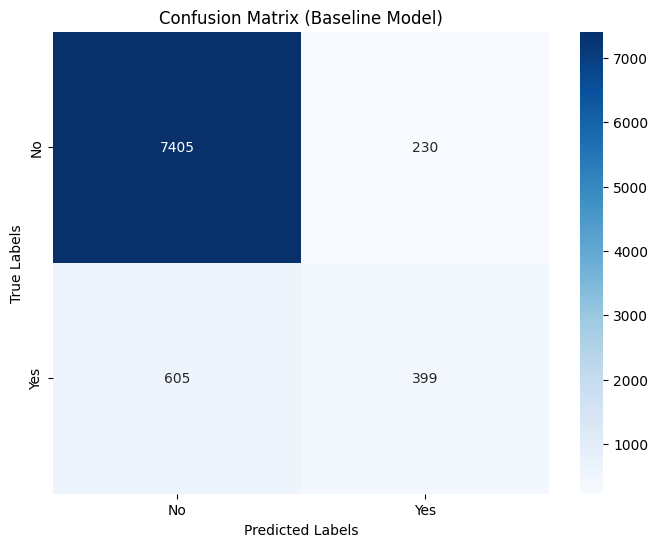

In [83]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Baseline Model)')
plt.show()

### ROC Curve

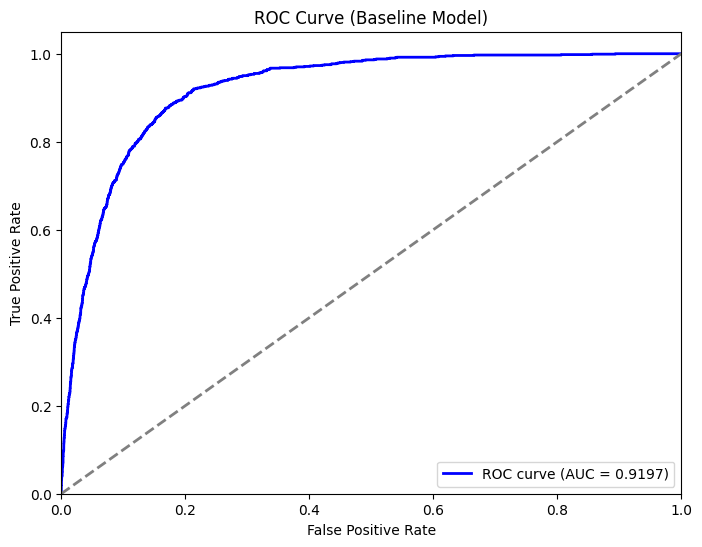

In [85]:
auc_score = roc_auc_score(y_test, y_test_proba)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Baseline Model)')
plt.legend(loc="lower right")
plt.show()

# Baseline Model Summary

The baseline model shows solid overall performance for an initial implementation. The accuracy stands at a respectable 90%, and the ROC AUC score of 0.9197 highlights its capability to distinguish between positive and negative cases effectively.

However, the recall for class "Yes" (true positives) is relatively low at 40%, meaning the model misses many opportunities to identify actual term deposit subscriptions. Despite this, the model's precision for class "Yes" (63%) ensures that the predictions for term deposits are relatively reliable.

For a baseline model, these results are promising!!